In [15]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

!pip install xgboost

import xgboost as xgb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 49.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 46.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [7]:
# Preprocessing

df = df.fillna(0)
all_train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
train_df, val_df = train_test_split(all_train_df, test_size=0.25, random_state=1)

y_train = train_df['fuel_efficiency_mpg'].values
y_all_train = all_train_df['fuel_efficiency_mpg'].values
y_val = val_df['fuel_efficiency_mpg'].values
y_test = test_df['fuel_efficiency_mpg'].values
del train_df['fuel_efficiency_mpg']
del all_train_df['fuel_efficiency_mpg']
del val_df['fuel_efficiency_mpg']
del test_df['fuel_efficiency_mpg']

train_dict = train_df.to_dict(orient='records')
all_train_dict = all_train_df.to_dict(orient='records')
val_dict = val_df.to_dict(orient='records')
test_dict = test_df.to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_all_train= dv.transform(all_train_dict)
X_test = dv.transform(test_dict)



# Question 1
Let's train a decision tree regressor to predict the `fuel_efficiency_mpg` variable.

Train a model with `max_depth=1`.
Which feature is used for splitting the data?

- 'vehicle_weight'
- 'model_year'
- 'origin'
- 'fuel_type'

In [8]:
dt = DecisionTreeRegressor(max_depth=1, random_state=1)
dt.fit(X_train,y_train)

print(export_text(dt, feature_names=dv.get_feature_names_out()))


|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



# Question 2
Train a random forest regressor with these parameters:

- `n_estimators=10`
- `random_state=1`
- `n_jobs=-1` (optional - to make training faster)

What's the RMSE of this model on the validation data?

- 0.045
- 0.45
- 4.5
- 45.0
#

In [9]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(np.sqrt(mean_squared_error(y_pred, y_val)))



0.4595777223092726


# Question 3
Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.

Set `random_state` to `1`.

Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200
If it doesn't stop improving, use the latest iteration number in your answer.



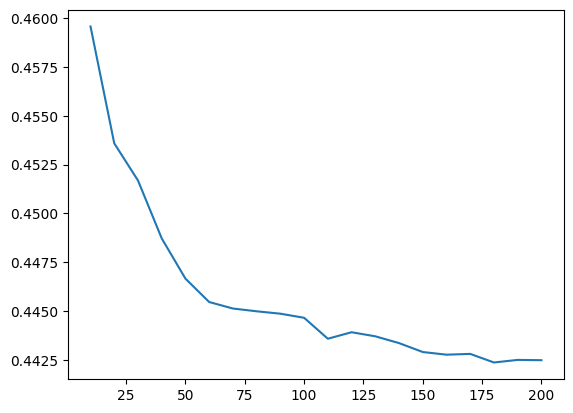

In [10]:
range_estimators = np.arange(10,210,10)
results = []

for i in range_estimators:
    rf = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    results.append(np.sqrt(mean_squared_error(y_pred, y_val)))
    
plt.plot(range_estimators, results)


# Question 4
Let's select the best `max_depth`:

Try different values of `max_depth`: `[10, 15, 20, 25]`

For each of these values,
try different values of n_estimators from 10 till 200 (with step 10)
calculate the mean RMSE

Fix the random seed: `random_state=1`

What's the best `max_depth`, using the mean RMSE?

- 10
- 15
- 20
- 25

In [11]:
max_depths = [10,15,20,25]
rmse = []
for m in max_depths:
    rf = RandomForestRegressor(max_depth=m, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse.append(np.sqrt(mean_squared_error(y_pred, y_val)))

for i,j in zip(max_depths, rmse):
    #print(f'max_depth:{i}, rmse:{j}')
    print('max_depth:%d, rmse:%.4f' % (i,j))

max_depth:10, rmse:0.4412
max_depth:15, rmse:0.4443
max_depth:20, rmse:0.4453
max_depth:25, rmse:0.4448


# Question 5
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)


Get the feature importance information from this model
What's the most important feature (among these 4)?

- `vehicle_weight`
- `horsepower`
- `acceleration`
- `engine_displacement`


In [13]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
#for i,j in zip(dv.get_feature_names_out(), rf.feature_importances_):
#    print("%s: %f" % (i,j))

results_df = pd.DataFrame({'feature':dv.get_feature_names_out(),'importance':rf.feature_importances_})

print(results_df.sort_values(by='importance', ascending=False))

                         feature  importance
13                vehicle_weight    0.959150
6                     horsepower    0.015998
0                   acceleration    0.011480
3            engine_displacement    0.003273
7                     model_year    0.003212
8                  num_cylinders    0.002343
9                      num_doors    0.001635
12                    origin=USA    0.000540
11                 origin=Europe    0.000519
10                   origin=Asia    0.000462
5             fuel_type=Gasoline    0.000360
1     drivetrain=All-wheel drive    0.000357
2   drivetrain=Front-wheel drive    0.000345
4               fuel_type=Diesel    0.000325


# Question 6
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

Install XGBoost
Create DMatrix for train and validation
Create a watchlist
Train a model with these parameters for 100 rounds:

    xgb_params = {
        'eta': 0.3, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- Both give equal value


In [24]:
etas = [0.3,0.1]

features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)


for eta in etas:
    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

    #model = xgb.train(
    #    xgb_params,
    #    dtrain,
    #    evals=watchlist,
    #    verbose_eval=0,
    #    num_boost_round=100,
    #    evals_result=evals_result
    #)

    model = xgb.train(xgb_params,dtrain=dtrain,num_boost_round=100)

    y_pred = model.predict(dval)
    score = np.sqrt(mean_squared_error(y_val, y_pred))

    print(f'eta:{eta}, score:%.3f' % score)


eta:0.3, score:0.450
eta:0.1, score:0.426
